# Using Transfer Learning for Classification

# Fine-tuning InceptionV3 for flowers classification

In this task you will fine-tune InceptionV3 architecture for flowers classification task.

InceptionV3 architecture (https://research.googleblog.com/2016/03/train-your-own-image-classifier-with.html):
<img src="https://github.com/hse-aml/intro-to-dl/blob/master/week3/images/inceptionv3.png?raw=1" style="width:70%">


Inceptionv3 is a convolutional neural network for assisting in image analysis and object detection, and got its start as a module for Googlenet. It is the third edition of Google's Inception Convolutional Neural Network, originally introduced during the ImageNet Recognition Challenge. 

Just as ImageNet can be thought of as a database of classified visual objects, Inception helps classification of objects in the world of computer vision. One such use is in life sciences, where it aids in the research of Leukemia. The original name (Inception) was codenamed this way after a popular "'we need to go deeper' internet meme" went viral quoting a phrase from Inception film of Christopher Nolan.

<img src="https://i.kym-cdn.com/photos/images/newsfeed/000/531/557/a88.jpg">




# DataSet we will use


Flowers classification dataset (http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) consists of 102 flower categories commonly occurring in the United Kingdom. Each class contains between 40 and 258 images:
<img src="https://github.com/hse-aml/intro-to-dl/blob/master/week3/images/flowers.jpg?raw=1" style="width:70%">

In [ ]:
### To run on Colabs 

import os

def download_github_code(path):
    filename = path.rsplit("/")[-1]
    os.system("shred -u {}".format(filename))
    os.system("wget https://raw.githubusercontent.com/MustaphaBounoua/Flowers-Classification/main/{} -O {}".format(path, filename))

download_github_code('callback.py')
download_github_code('tqdm_util.py')
download_github_code('util.py')

In [1]:
# All the packages we will need

import tensorflow as tf
import keras
from keras import backend as K
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
print(tf.__version__)
print(keras.__version__)
import cv2  
from sklearn.model_selection import train_test_split
import scipy.io
import os
import tarfile
import callback
from util import download_file
import pandas as pd
import plotly.express as px

2.4.1
2.4.3


# Load dataset

The dataset is made of 102 class of flowers. The flowers chosen to be flower commonly occuring in the United Kingdom. Each class consists of between 40 and 258 images.

Dataset was downloaded for you, it takes 12 min and 400mb.
Relevant links (just in case):
- http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html
- http://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz
- http://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat

In [1]:
FOLDER_DATA_RAW = "./data/" 
FOLDER_MODEL="./model/"

if not os.path.exists(FOLDER_DATA_RAW):
    os.mkdir(FOLDER_DATA_RAW)
if not os.path.exists(FOLDER_MODEL):
    os.mkdir(FOLDER_MODEL)

IMAGES_FILE = FOLDER_DATA_RAW + "102flowers.tgz"
LABELS_FILE = FOLDER_DATA_RAW + "imagelabels.mat"
IMAGES_URL = "http://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz"
IMAGES_LABEL_URL = "http://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat"

#download_file(IMAGES_URL,IMAGES_FILE) 
#download_file(IMAGES_LABEL_URL,LABELS_FILE) 

# Prepare images for model

In [3]:
# we will crop and resize input images to IMG_SIZE x IMG_SIZE
IMG_SIZE = 250

In [4]:
def decode_image_from_raw_bytes(raw_bytes):
    img = cv2.imdecode(np.asarray(bytearray(raw_bytes), dtype=np.uint8), 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

In [5]:
def image_center_crop(img):
    """
    Makes a square center crop of an img, which is a [h, w, 3] numpy array.
    Returns [min(h, w), min(h, w), 3] output with same width and height.
    For cropping use numpy slicing.
    """
    h,w,_ = img.shape
    cropped_img = img[:min(h, w), :min(h, w),:]


    h,w = img.shape[0:2]
    if h == w:
        cropped_img = img
    elif h > w:
        start = (h-w)//2
        end = start + w
        cropped_img= img[start:start+w,:,:]
    else:
        start = (w-h)//2
        end = start + h
        cropped_img= img[:,start:start+h,:]
        
    # checks for errors
    h, w, c = img.shape
    assert cropped_img.shape == (min(h, w), min(h, w), c), "error in image_center_crop!"
    
    return cropped_img

In [6]:
def prepare_raw_bytes_for_model(raw_bytes, normalize_for_model=True):
    
    img = decode_image_from_raw_bytes(raw_bytes)  # decode image raw bytes to matrix
    img = image_center_crop(img)  # take squared center crop
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))  # resize for our model
    if normalize_for_model:
        img = img.astype("float32")  # prepare for normalization
        img = keras.applications.inception_v3.preprocess_input(img)  # normalize for model
    return img

In [7]:
# reads bytes directly from tar by filename (slow, but ok for testing, takes ~6 sec)
def read_raw_from_tar(tar_fn, fn):
    with tarfile.open(tar_fn) as f:
        m = f.getmember(fn)
        return f.extractfile(m).read()

(500, 591, 3)


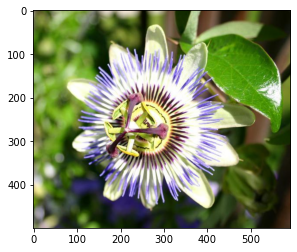

(250, 250, 3)


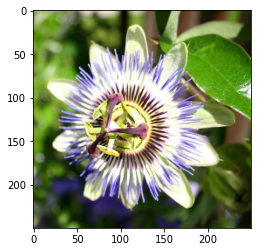

In [8]:
# test cropping
raw_bytes = read_raw_from_tar(IMAGES_FILE, "jpg/image_00001.jpg")

img = decode_image_from_raw_bytes(raw_bytes)
print(img.shape)
plt.imshow(img)
plt.show()

img = prepare_raw_bytes_for_model(raw_bytes, normalize_for_model=False)
print(img.shape)
plt.imshow(img)
plt.show()

# Prepare for training

In [9]:
# read all filenames and labels for them

# read filenames firectly from tar
def get_all_filenames(tar_fn):
    with tarfile.open(tar_fn) as f:
        return [m.name for m in f.getmembers() if m.isfile()]

all_files = sorted(get_all_filenames(IMAGES_FILE))  # list all files in tar sorted by name
all_labels = scipy.io.loadmat(LABELS_FILE)['labels'][0] - 1  # read class labels (0, 1, 2, ...)
# all_files and all_labels are aligned now
print(len(np.unique(all_labels)))

102


In [11]:
df = pd.DataFrame({"images":all_files,"labels":all_labels})
df = df.groupby("labels").count().reset_index()
fig = px.bar(df,x="labels",y="images")
fig.show()

In [12]:
# split into train/test
tr_files, te_files, tr_labels, te_labels = \
    train_test_split(all_files, all_labels, test_size=0.2, random_state=42, stratify=all_labels)

In [13]:
# will yield raw image bytes from tar with corresponding label
def raw_generator_with_label_from_tar(tar_fn, files, labels):
    label_by_fn = dict(zip(files, labels))
    with tarfile.open(tar_fn) as f:
        while True:
            m = f.next()
            if m is None:
                break
            if m.name in label_by_fn:
                yield f.extractfile(m).read(), label_by_fn[m.name]

In [14]:
# batch generator
BATCH_SIZE = 32
N_CLASSES = len(np.unique(all_labels))
def batch_generator(items, batch_size):
    """
    Batch generator that yields items in batches of size batch_size.
    """
    batch_list = []
    for index, item in enumerate(items):
      if index % batch_size == 0:
        if index !=0:
          batch_list.append(batch)
        batch = []
      batch.append(item)
    batch_list.append(batch)

    return batch_list
    

In [15]:
def train_generator(files, labels):
    while True:  # so that Keras can loop through this as long as it wants
        data = raw_generator_with_label_from_tar(IMAGES_FILE, files, labels)
        batch_list = batch_generator(data,BATCH_SIZE)
        for batch in batch_list:
            # prepare batch images
            batch_imgs = []
            batch_targets = []
            for raw, label in batch:
                img = prepare_raw_bytes_for_model(raw)
                batch_imgs.append(img)
                batch_targets.append(label)
            # stack images into 4D tensor [batch_size, img_size, img_size, 3]
            batch_imgs = np.stack(batch_imgs, axis=0)
            # convert targets into 2D tensor [batch_size, num_classes]
            batch_targets = tf.keras.utils.to_categorical(batch_targets, N_CLASSES)
            yield batch_imgs, batch_targets

(32, 250, 250, 3)


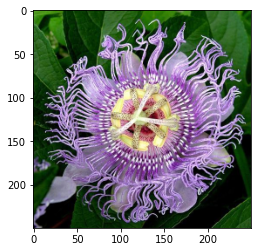

In [16]:
x = next(train_generator(tr_files, tr_labels))
x = next(train_generator(tr_files, tr_labels))
print(x[0].shape)
plt.imshow(np.clip(x[0][0] / 2. + 0.5, 0, 1))

# Training

In [17]:
tf.keras.backend.clear_session()

You cannot train such a huge architecture from scratch with such a small dataset.

But using fine-tuning of last layers of pre-trained network you can get a pretty good classifier very quickly.

In [18]:
def inception(use_imagenet=True):
    # load pre-trained model graph, don't add final layer
    model = keras.applications.InceptionV3(include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3),
                                          weights='imagenet' if use_imagenet else None)
    # add global pooling just like in InceptionV3
    new_output = keras.layers.GlobalAveragePooling2D()(model.output)
    # add new dense layer for our labels
    new_output = keras.layers.Dense(N_CLASSES, activation='softmax')(new_output)
    
    model = keras.engine.training.Model(model.inputs, new_output)
    return model

In [19]:
model = inception()
model.summary()

In [21]:
# how many layers our model has
print(len(model.layers))

313


In [22]:
# set all layers trainable by default
for layer in model.layers:
    layer.trainable = True
    if isinstance(layer, keras.layers.BatchNormalization):
        # we do aggressive exponential smoothing of batch norm
        # parameters to faster adjust to our new dataset
        layer.momentum = 0.9
    
# fix deep layers (fine-tuning only last 50)
for layer in model.layers[:-50]:
    # fix all but batch norm layers, because we neeed to update moving averages for a new dataset!
    if not isinstance(layer, keras.layers.BatchNormalization):
        layer.trainable = False

In [23]:
# compile new model
model.compile(
    loss='categorical_crossentropy',  # we train 102-way classification
    optimizer=tf.keras.optimizers.Adamax(lr=1e-2),  # we can take big lr here because we fixed first layers
    metrics=['accuracy']  # report accuracy during training
)

In [24]:
# we will save model checkpoints to continue training in case of kernel death
model_filename = FOLDER_MODEL+'flowers.{0:03d}.hdf5'
last_finished_epoch = None

#### uncomment below to continue training from model checkpoint
#### fill `last_finished_epoch` with your latest finished epoch
# from keras.models import load_model
# s = reset_tf_session()
# last_finished_epoch = 10
# model = load_model(model_filename.format(last_finished_epoch))

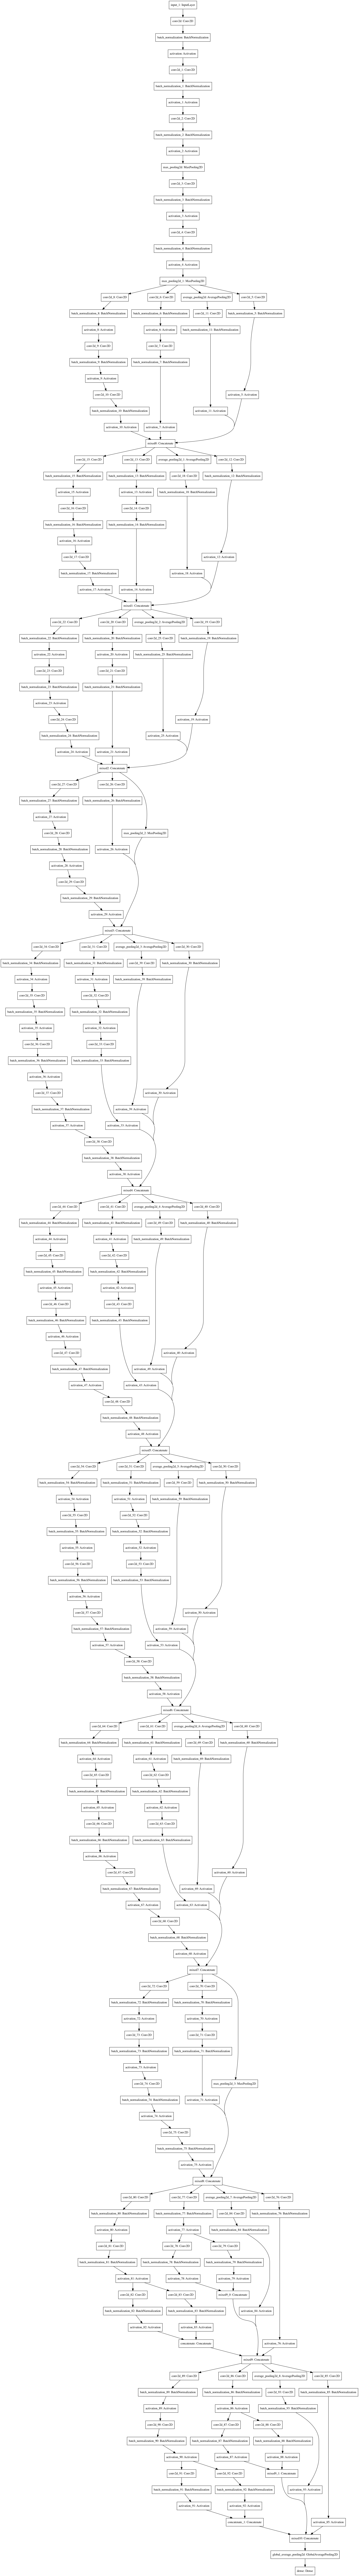

In [25]:
keras.utils.plot_model(model, "assets/model.png")

In [31]:
import datetime
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [ ]:
%tensorboard --logdir logs/fit

In [ ]:
# fine tune for 2 epochs (full passes through all training data)
# we make 2*8 epochs, where epoch is 1/8 of our training data to see progress more often
!rm -rf ./logs/

model.fit_generator(
    train_generator(tr_files, tr_labels),
    epochs=2 * 8,
    validation_data= train_generator(te_files, te_labels), 
    callbacks=[tensorboard_callback],
    initial_epoch=last_finished_epoch or 0
)